# Analyzing Neighborhoods of Philadelphia For Starting A New Restaurant

## Import libraries

In [63]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup
import csv

!pip install geocoder
import geocoder

import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


## Scrape the neighborhoods list from wikipedia

In [64]:

source = requests.get('https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Philadelphia').text 
soup = BeautifulSoup(source, 'lxml')
mwcg = soup.find_all(class_ = "mw-category-group")

## Save the data in a csv file

In [65]:
csv_file = open('philly.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Neighbourhood'])
length = len(mwcg) # Gets the length of number of `mw-category-groups` present

for i in range(1, length):  # Gets all the neighbourhoods
    lists = mwcg [i].find_all('a')
    for list in lists:
        nbd = list.get('title') # Gets the title of the neighbourhood
        csv_writer.writerow([nbd]) # Writes the name of the neighbourhood in the csv file

csv_file.close()

## import the data from the csv file

In [66]:
philly_raw = pd.read_csv('philly.csv',encoding='cp1252')
philly_raw.head()

,Neighbourhood
0,"Category:Bridesburg-Kensington-Richmond, Phila..."
1,"Category:Bridesburg, Philadelphia"
2,"Category:Callowhill, Philadelphia"
3,"Category:Chestnut Hill, Philadelphia"
4,"Category:Chinatown, Philadelphia"


## data cleaning

In [67]:
# filtering the raw data to include only the list of neighborhoods
philly = philly_raw[51:]
philly.reset_index(drop=True,inplace=True)
# split the colnmn value 
new = philly["Neighbourhood"].str.split(",", n = 1, expand = True)
# assign the name of the neighborhoods to a new column 'Neighborhoods'
philly['Neighborhoods']=new[0]
# drop the old 'Neighbourhood' column
philly.drop(columns =["Neighbourhood"], inplace = True)

C:\Users\Tianyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [68]:
# clean up the column value to include only the name of the neighborhood
philly = pd.DataFrame(philly['Neighborhoods'].str.replace(r"\(.*\)",""))
philly = pd.DataFrame(philly['Neighborhoods'].str.replace(r"\(.*",""))

In [69]:
# check how many neighborhood we have now
philly.head()

,Neighborhoods
0,Academy Gardens
1,Allegheny West
2,Andorra
3,Angora
4,Ashton-Woodenbridge


## Add latitudes and longtitudes to neighborhoods

In [70]:

# Initialize varialbes
lat = []
lng = []
lat_lng_coords = None

# define a list with neighborhoods names
neighbourhoods = philly['Neighborhoods']


# initialize your variable to None
lat_lng_coords = None

# Store latitude and longitude values in lat and lng
for nh in neighbourhoods:
    g = geocoder.arcgis('{}, Philadelphia, US'.format(nh))
    lat_lng_coords = g.latlng
    lat.append(lat_lng_coords[0])
    lng.append(lat_lng_coords[1])

philly_data = philly
philly_data['Latitude'] = lat
philly_data['Longitude'] = lng

In [71]:
philly_data.head()

,Neighborhoods,Latitude,Longitude
0,Academy Gardens,40.06178,-74.99628
1,Allegheny West,40.00361,-75.17716
2,Andorra,40.07261,-75.23129
3,Angora,39.94399,-75.23803
4,Ashton-Woodenbridge,40.07178,-75.02295


In [72]:
#filter the data to exclude incorrect coordinates 
is_in_philly = (39<philly_data['Latitude']) & (philly_data['Latitude']<41) & (-76<philly_data['Longitude']) & (philly_data['Longitude']<-74)
philly_data = philly_data[is_in_philly]
philly_data

,Neighborhoods,Latitude,Longitude
0,Academy Gardens,40.061780,-74.996280
1,Allegheny West,40.003610,-75.177160
2,Andorra,40.072610,-75.231290
3,Angora,39.943990,-75.238030
4,Ashton-Woodenbridge,40.071780,-75.022950
5,Bartram Village,39.930300,-75.216900
7,Bella Vista,39.935390,-75.157120
8,Belmont Village,39.965720,-75.202740
9,Black Bottom,39.981063,-75.207069
10,Blue Bell Hill,40.122514,-74.984596


In [73]:
#define latitude and longitude of Philadelphia
latitude = 39.952583
longitude = -75.165222
print('The geograpical coordinate of Philadelphia are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Philadelphia are 39.952583, -75.165222.


In [74]:
# plot the map around Philadelphia and label all neighborhoods as dots on the map using the geographical information 
man_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(philly_data['Latitude'], philly_data['Longitude'], philly_data['Neighborhoods']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(man_map)  
    
man_map

## So far, we have finished the data cleaning process which give us a dataframe with the name and geographical infomation of all available neighborhoods of Philadelphia. Next, we will use FourSquare API to obtain venue information for each neighborhoods.

In [75]:
# Set up the paramenters for FourSquare inquiries
CLIENT_ID = 'H1LRIHQWKHBIXXYVKKZZY2YB3JJVSFNSHNAJOJODEX1F0Y1D' # your Foursquare ID
CLIENT_SECRET = 'Q2DHPFAQCKDU3TQN3G3DDXFVFJ5BFLHK3DL3CGBPJLJ1JZBF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: H1LRIHQWKHBIXXYVKKZZY2YB3JJVSFNSHNAJOJODEX1F0Y1D
CLIENT_SECRET:Q2DHPFAQCKDU3TQN3G3DDXFVFJ5BFLHK3DL3CGBPJLJ1JZBF


In [76]:
# Define a function to get the name of the category
def get_category_type(row):
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [77]:
#Create a function to repeat the same process to all the neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [78]:
# get the venue information for all neighborhoods in philadelphia using the function we have defined above
philly_venues = getNearbyVenues(names=philly['Neighborhoods'],
                                   latitudes=philly['Latitude'],
                                   longitudes=philly['Longitude']
                                  )
philly_venues.shape

Academy Gardens
Allegheny West
Andorra
Angora
Ashton-Woodenbridge
Bartram Village
Beggarstown
Bella Vista
Belmont Village
Black Bottom
Blue Bell Hill 
Brewerytown
Bridesburg-Kensington-Richmond
Bridesburg
Burholme
Bustleton
Byberry
Callowhill
Carroll Park
Castor Gardens
Cathedral Park
Cecil B. Moore
Cedar Park
Cedarbrook
Centennial District 
Center City East
Central South Philadelphia
Chestnut Hill Historic District 
Chestnut Hill
Chinatown
Clearview
Cobbs Creek
Crescentville
Crestmont Farms
Devil's Pocket
Dickinson Square West
Druim Moir Historic District
Dunlap
East Falls
East Oak Lane
East Passyunk Crossing
Eastwick
Elfreth's Alley
Elmwood Park
Fabric Row 
Fairhill
Fairmount
Feltonville
Fern Rock
Fishtown
Fitler Square
Fox Chase
Francisville
Frankford
Franklintown
Franklinville
French Quarter
Garden Court
Germantown
Girard Estate
Glenwood
Grays Ferry
Haddington
Harrowgate
Hartranft
Haverford North
Hawthorne
Hog Island
Holme Circle
Holmesburg
Hunting Park
Industrial
Italian Market
Je

(4440, 7)

In [79]:
philly_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Academy Gardens,40.06178,-74.99628,Aquatic Fitness Center,40.063243,-75.000096,Gym / Fitness Center
1,Academy Gardens,40.06178,-74.99628,Byrne Golf Course,40.060327,-74.998063,Golf Course
2,Academy Gardens,40.06178,-74.99628,John F. Byrne Golf Course,40.060158,-74.998070,Golf Course
3,Academy Gardens,40.06178,-74.99628,JL's Beer Box,40.063286,-74.999481,Liquor Store
4,Allegheny West,40.00361,-75.17716,SHARE Food Program,40.006208,-75.177470,Grocery Store


In [80]:
# Check how many unique categories were found in the neighbothoods of Philadelphia
print('There are {} uniques categories.'.format(len(philly_venues['Venue Category'].unique())))

There are 315 uniques categories.


In [81]:
# one hot encoding
philly_onehot = pd.get_dummies(philly_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
philly_onehot['Neighborhood'] = philly_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [philly_onehot.columns[-1]] + philly_onehot.columns[:-1].values.tolist()
philly_onehot = philly_onehot[fixed_columns]
philly_onehot.head()

,Neighborhood,ATM,Adult Boutique,Advertising Agency,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Roller Rink,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stadium,Steakhouse,Storage Facility,St

In [82]:
# group by Neighborhood and reset index
philly_grouped = philly_onehot.groupby('Neighborhood').mean().reset_index()
philly_grouped.head()

,Neighborhood,ATM,Adult Boutique,Advertising Agency,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Roller Rink,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stadium,Steakhouse,Storage Facility,St

In [83]:
# define a function to return the top most popular venues
def top_common_venues(row, top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_venues]

In [84]:
# use the function defined above to get the top 10 most popular venues in each neighborhood in Philadelphia
top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighborhood'] = philly_grouped['Neighborhood']

for ind in np.arange(philly_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = top_common_venues(philly_grouped.iloc[ind, :], top_venues)

neighbourhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Academy Gardens,Golf Course,Liquor Store,Gym / Fitness Center,Zoo Exhibit,Farm,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit
1,Allegheny West,Intersection,Grocery Store,Pizza Place,Fast Food Restaurant,Farm,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
2,Andorra,American Restaurant,Playground,Zoo Exhibit,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
3,Angora,Chinese Restaurant,Park,Grocery Store,Shopping Plaza,Donut Shop,American Restaurant,Discount Store,Road,Supermarket,Light Rail Station
4,Ashton-Woodenbridge,Liquor Store,Business Service,Miscellaneous Shop,Zoo Exhibit,Farmers Market,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm


In [85]:
# drop the 'Neighborhood' column for K-means clustering
philly_grouped_clustering = philly_grouped.drop('Neighborhood', 1)

In [86]:
# define the plotting parameters
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [87]:
# find the best k value for K-means clusering
max_range = 15 #Max range 15 (number of clusters)

from sklearn.metrics import silhouette_samples, silhouette_score


indices = []
scores = []

for philly_clusters in range(2, max_range) :
    
    # Run k-means clustering
    philly_gc = philly_grouped_clustering
    kmeans = KMeans(n_clusters = philly_clusters, init = 'k-means++', random_state = 0).fit_predict(philly_gc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(philly_gc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(philly_clusters)
    scores.append(score)

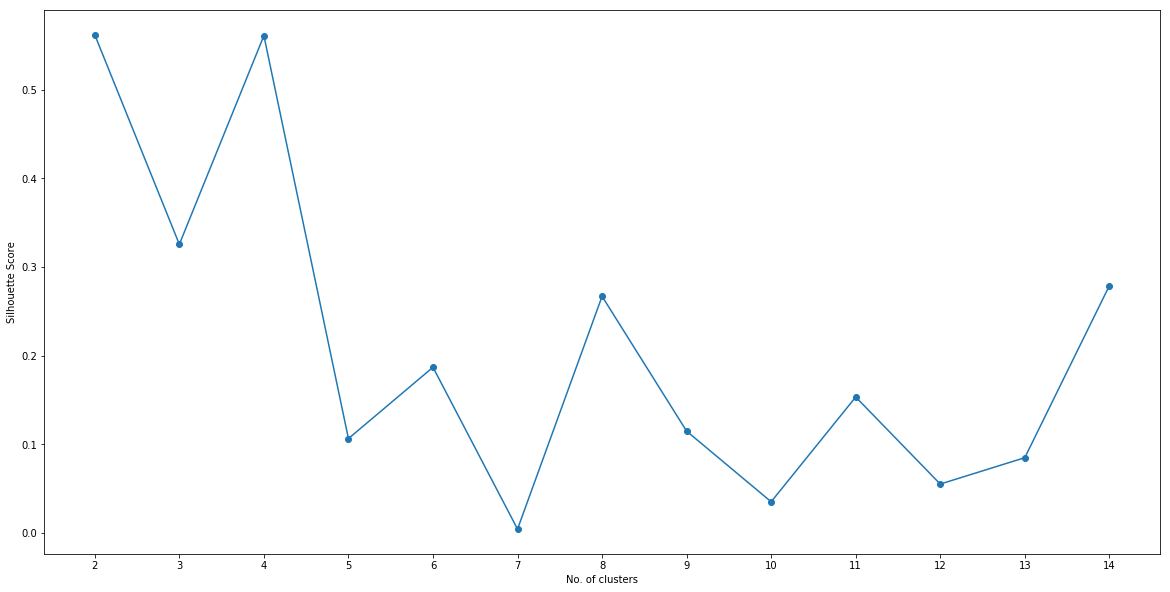

In [88]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [89]:
# use the optimum k value from the previous step
opt_value = 7
philly_clusters = opt_value

# Run k-means clustering
philly_gc = philly_grouped_clustering
kmeans = KMeans(n_clusters = philly_clusters, init = 'k-means++', random_state = 0).fit(philly_gc)

In [90]:
# Add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [91]:
philly_merged = philly_data.rename(columns={"Neighborhoods": "Neighborhood"})
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
philly_merged = philly_merged.join(neighbourhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
philly_merged.dropna(inplace = True)
philly_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Academy Gardens,40.06178,-74.99628,0.0,Golf Course,Liquor Store,Gym / Fitness Center,Zoo Exhibit,Farm,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit
1,Allegheny West,40.00361,-75.17716,6.0,Intersection,Grocery Store,Pizza Place,Fast Food Restaurant,Farm,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
2,Andorra,40.07261,-75.23129,1.0,American Restaurant,Playground,Zoo Exhibit,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
3,Angora,39.94399,-75.23803,0.0,Chinese Restaurant,Park,Grocery Store,Shopping Plaza,Donut Shop,American Restaurant,Discount Store,Road,Supermarket,Light Rail Station
4,Ashton-Woodenbridge,40.07178,-75.02295,0.0,Liquor Store,Business Service,Miscellaneous Shop,Zoo Exhibit,Farmers Market,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm


In [92]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(opt_value)
ys = [i + x + (i*x)**2 for i in range(opt_value)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(philly_merged['Latitude'], philly_merged['Longitude'], philly_merged['Neighborhood'], philly_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [93]:
# neighborhoods in cluster 0
val = 0
philly_merged.loc[philly_merged['Cluster Labels'] == (val), philly_merged.columns[[0] + np.arange(4, philly_merged.shape[1]).tolist()]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Academy Gardens,Golf Course,Liquor Store,Gym / Fitness Center,Zoo Exhibit,Farm,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit
3,Angora,Chinese Restaurant,Park,Grocery Store,Shopping Plaza,Donut Shop,American Restaurant,Discount Store,Road,Supermarket,Light Rail Station
4,Ashton-Woodenbridge,Liquor Store,Business Service,Miscellaneous Shop,Zoo Exhibit,Farmers Market,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
5,Bartram Village,Convenience Store,Print Shop,Train,Platform,Garden,Plaza,Fish Market,Filipino Restaurant,Fast Food Restaurant,Flea Market
7,Bella Vista,Mexican Restaurant,Coffee Shop,Italian Restaurant,Vietnamese Restaurant,Sandwich Place,Bar,Pizza Place,Bakery,Pub,Mediterranean Restaurant
8,Belmont Village,Bakery,Cosmetics Shop,Discount Store,Breakfast Spot,Mobile Phone Shop,Event Space,Shoe Store,Caribbean Restaurant,Light Rail Station,Pizza Place
9,Black Bottom,Museum,Art Gallery,Historic Site,Cosmetics Shop,Food Truck,Botanical Garden,Fountain,Café,Park,Scenic Lookout
11,Brewerytown,Café,Deli / Bodega,Brewery,Discount Store,Grocery Store,Health & Beauty Service,Liquor Store,Sandwich Place,Ethiopian Restaurant,Pizza Place
16,Byberry,Art Gallery,Fast Food Restaurant,Brewery,Dog Run,Playground,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
17,Callowhill,Pizza Place,Japanese Restaurant,Bar,Park,Sandwich Place,Rental Car Location,Coffee Shop,Food Truck,Gym / Fitness Center,Hotel Bar


In [94]:
# neighborhoods in cluster 1
val = 1
philly_merged.loc[philly_merged['Cluster Labels'] == (val), philly_merged.columns[[0] + np.arange(4, philly_merged.shape[1]).tolist()]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Andorra,American Restaurant,Playground,Zoo Exhibit,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm


In [95]:
# neighborhoods in cluster 2
val = 2
philly_merged.loc[philly_merged['Cluster Labels'] == (val), philly_merged.columns[[0] + np.arange(4, philly_merged.shape[1]).tolist()]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,East Oak Lane,Lake,Zoo Exhibit,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market


In [96]:
# neighborhoods in cluster 3
val = 3
philly_merged.loc[philly_merged['Cluster Labels'] == (val), philly_merged.columns[[0] + np.arange(4, philly_merged.shape[1]).tolist()]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
67,Hog Island,Airport Terminal,Zoo Exhibit,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market


In [97]:
# neighborhoods in cluster 4
val = 4
philly_merged.loc[philly_merged['Cluster Labels'] == (val), philly_merged.columns[[0] + np.arange(4, philly_merged.shape[1]).tolist()]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Crestmont Farms,Café,Zoo Exhibit,Farmers Market,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Fast Food Restaurant


In [98]:
# neighborhoods in cluster 5
val = 5
philly_merged.loc[philly_merged['Cluster Labels'] == (val), philly_merged.columns[[0] + np.arange(4, philly_merged.shape[1]).tolist()]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Blue Bell Hill,Gym / Fitness Center,Border Crossing,Farmers Market,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm


In [99]:
# neighborhoods in cluster 6
val = 6
philly_merged.loc[philly_merged['Cluster Labels'] == (val), philly_merged.columns[[0] + np.arange(4, philly_merged.shape[1]).tolist()]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Allegheny West,Intersection,Grocery Store,Pizza Place,Fast Food Restaurant,Farm,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
12,Bridesburg-Kensington-Richmond,Pizza Place,Convenience Store,Clothing Store,Speakeasy,Bus Station,Sporting Goods Shop,Pharmacy,Gym / Fitness Center,Food & Drink Shop,Ice Cream Shop
13,Bridesburg,Pizza Place,Convenience Store,Clothing Store,Speakeasy,Bus Station,Sporting Goods Shop,Pharmacy,Gym / Fitness Center,Food & Drink Shop,Ice Cream Shop
14,Burholme,Pharmacy,Ice Cream Shop,Pizza Place,Deli / Bodega,Clothing Store,Coffee Shop,Donut Shop,Train Station,Diner,Bar
15,Bustleton,Pizza Place,Convenience Store,Sports Bar,Fried Chicken Joint,Men's Store,Beer Garden,Dry Cleaner,Seafood Restaurant,Pet Store,Bank
23,Cedarbrook,Shoe Store,Fried Chicken Joint,Pizza Place,Ice Cream Shop,Discount Store,Mobile Phone Shop,Men's Store,Food & Drink Shop,Clothing Store,Caribbean Restaurant
32,Crescentville,Convenience Store,Fast Food Restaurant,Park,Pharmacy,Donut Shop,Discount Store,Bank,Fried Chicken Joint,Fish Market,Filipino Restaurant
37,Dunlap,Breakfast Spot,Shoe Store,Pizza Place,Convenience Store,Pharmacy,Women's Store,Deli / Bodega,Caribbean Restaurant,Bar,Clothing Store
38,East Falls,Pizza Place,ATM,Vegetarian / Vegan Restaurant,Indian Restaurant,Deli / Bodega,Pharmacy,Soccer Field,Flea Market,Flower Shop,Pub
43,Elmwood Park,Discount Store,Pizza Place,Chinese Restaurant,Convenience Store,Grocery Store,Seafood Restaurant,Pharmacy,Park,Monument / Landmark,Bowling Alley


## To conclude, we have used k-means clustering to divide all neighborhoods of Philadelphia into 7 clusters. By looking at the top-10 most polupar venues for neighborhoods in each cluster, it turns out that neighborhoods in cluster number are the best option to start a new restaurant. Depending on the cuisine style of the restaurant, we can make recommendations for specific neighborhoods for our client. For example, Bella Vista, East Passyunk Crossing and Southwark could be the potential neighborhoods if our client would like to open a Mexican restaurant.